In [1]:
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cf
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import gribscan
import intake
import eccodes
import healpy as hp

Open the catalog with nextGEMS data

In [2]:
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")

We will work with dask for both models, although in case of ICON it's even not necessary

In [3]:
from dask.distributed import Client
import dask
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
dask.config.set({'temporary_directory': '/scratch/a/a270088/dask/'})
# client = Client(n_workers=5, threads_per_worker=1, memory_limit='50GB')
client = Client(n_workers=10, threads_per_worker=1, memory_limit='10GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/a270088/levante-spawner-preset//proxy/8787/status,
Dashboard: /user/a270088/levante-spawner-preset//proxy/8787/status,Workers: 10
Total threads: 10,Total memory: 93.13 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42493,Workers: 10
Dashboard: /user/a270088/levante-spawner-preset//proxy/8787/status,Total threads: 10
Started: Just now,Total memory: 93.13 GiB
Comm: tcp://127.0.0.1:44015,Total threads: 1
Dashboard: /user/a270088/levante-spawner-preset//proxy/44477/status,Memory: 9.31 GiB
Nanny: tcp://127.0.0.1:38355,


In [4]:
data_ifs = cat.IFS['IFS_9-FESOM_5-production']['2D_hourly_healpix512'].to_dask() 

/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


In [5]:
data_icon = cat.ICON['ngc4008'](time="PT3H", zoom=9, chunks="auto").to_dask()

/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


In [6]:
data_ifs_oce = cat.IFS['IFS_9-FESOM_5-production']['2D_daily_healpix512_ocean'].to_dask() 

/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


In [7]:
data_ifs_oce_3d = cat.IFS['IFS_9-FESOM_5-production']['3D_daily_healpix512_ocean'].to_dask() 

/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


In [8]:
data_icon_oce = cat.ICON['ngc4008'](time="P1D", zoom=9, chunks="auto").to_dask()

/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


## One point data

In [9]:
data_example = data_ifs['2t'][-1,:]

The length is 3145728, so it's zoom level 9

In [10]:
len(data_example)

3145728

We start by selecting data for the point. We can find index in healpix mesh, that is closest to our point. It will be the same for both models:

In [11]:
pix = hp.ang2pix(
        hp.npix2nside(len(data_example)), theta=9.98737477, phi=49.70353785, nest=True, lonlat=True
    )

In [12]:
pix

178005

In [13]:
%%time
point_data = data_ifs['2t'].sel(time='2030')[:,pix].compute()

CPU times: user 37.8 s, sys: 2.69 s, total: 40.5 s
Wall time: 2min 28s


We select the same number of time steps (8 time steps more actually :))

In [14]:
data_icon['tas'].sel(time=slice('2030', '2032'))

<xarray.DataArray 'tas' (time: 8768, cell: 3145728)>
dask.array<getitem, shape=(8768, 3145728), dtype=float32, chunksize=(496, 32768), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2030-01-01 ... 2032-12-31T21:00:00
Dimensions without coordinates: cell
Attributes:
    cell_methods:   time: mean cell: mean
    component:      atmo
    grid_mapping:   crs
    long_name:      temperature in 2m
    standard_name:  air_temperature
    units:          K
    vgrid:          height_2m

In [15]:
%%time
point_data_icon = data_icon['tas'].sel(time=slice('2030', '2032'))[:,pix].compute()

CPU times: user 169 ms, sys: 19.7 ms, total: 189 ms
Wall time: 735 ms


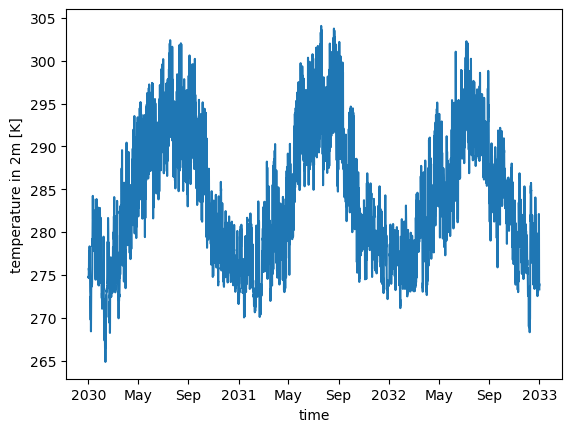

In [16]:
point_data_icon.plot()

Let's do the whole time series with ICON:

In [17]:
%%time
point_data_icon = data_icon['tas'][:,pix].compute()

CPU times: user 872 ms, sys: 177 ms, total: 1.05 s
Wall time: 3.97 s


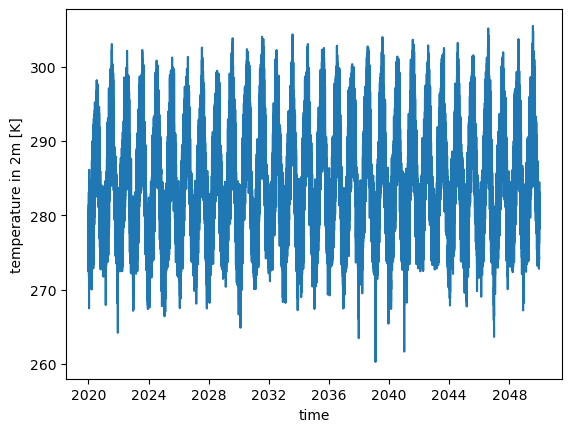

2025-04-01 14:57:43,692 - distributed.sizeof - WARNING - Sizeof calculation failed. Defaulting to -1 B
Traceback (most recent call last):
  File "/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/distributed/sizeof.py", line 17, in safe_sizeof
    return sizeof(obj)
  File "/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/dask/utils.py", line 773, in __call__
    return meth(arg, *args, **kwargs)
  File "/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/dask/sizeof.py", line 96, in sizeof_python_dict
    + sizeof(list(d.values()))
  File "/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/dask/utils.py", line 773, in __call__
    return meth(arg, *args, **kwargs)
  File "/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/dask/sizeof.py", line 59, in sizeof_python_collection
    return sys.getsizeof(seq) + sum(map(sizeof

In [18]:
point_data_icon.plot()

## 30 random points

In [20]:
import random

random.seed(42)  # Set a seed for reproducibility
random_numbers = [random.randint(0, 10000) for _ in range(30)]

print(random_numbers)

[1824, 409, 4506, 4012, 3657, 2286, 1679, 8935, 1424, 9674, 6912, 520, 488, 1535, 3582, 3811, 8279, 9863, 434, 9195, 3257, 8928, 6873, 3611, 7359, 9654, 4557, 106, 2615, 6924]


Only surface here to compare with earthkit

In [25]:
%%time
transect_fesom = data_ifs_oce_3d['avg_thetao'].sel(time='2030')[:,0,random_numbers].compute()

/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/distributed/client.py:3169: UserWarning: Sending large graph of size 51.12 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 3.89 s, sys: 364 ms, total: 4.25 s
Wall time: 10.5 s


In [26]:
%%time
transect_icon = data_icon_oce['to'].sel(time='2030')[:,0,random_numbers].compute()

CPU times: user 275 ms, sys: 26.4 ms, total: 302 ms
Wall time: 635 ms


In [27]:
%%time
transect_icon = data_icon_oce['to'][:,0,random_numbers].compute()

CPU times: user 6.92 s, sys: 595 ms, total: 7.51 s
Wall time: 21.3 s


## Small polygon

In [28]:
# 5° × 5° polygon over central Europe
# Split into separate longitude and latitude lists

# Extract coordinates
lats = [45.0, 50.0, 50.0, 45.0]  # Latitude values (phi)
lons = [0.0, 0.0, 5.0, 5.0]       # Longitude values (theta)

# Example usage with healpy (hp)
vec = hp.ang2vec(theta=lons, phi=lats, lonlat=True)

In [33]:
ipix_poly = hp.query_polygon(hp.npix2nside(len(data_example)), vertices=vec, inclusive=False, nest=True)

In [37]:
%%time
poly_ifs = data_ifs['2t'].sel(time='2030')[:,ipix_poly].compute()

CPU times: user 31.7 s, sys: 2.5 s, total: 34.2 s
Wall time: 58.9 s


In [35]:
%%time
poly_icon = data_icon['tas'].sel(time=slice('2030', '2032'))[:,ipix_poly].compute()

CPU times: user 200 ms, sys: 59.3 ms, total: 259 ms
Wall time: 425 ms


## SSH variability

In [38]:
%%time

ssh = data_ifs_oce['avg_zos'].std(dim='time').compute()

/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/distributed/client.py:3169: UserWarning: Sending large graph of size 52.93 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CPU times: user 2min 4s, sys: 11.1 s, total: 2min 15s
Wall time: 5min 38s


In [41]:
%%time
ssh_icon = data_icon_oce['zos'].std(dim='time').compute()

/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, 

CPU times: user 25.2 s, sys: 2.43 s, total: 27.6 s
Wall time: 1min 29s


/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


## Range (consecutive points)

Let's take some area, for simplicity just represented by first 100K points

In [42]:
%%time
area_data = data_ifs['2t'].sel(time='2030')[:,list(range(100000))].mean(dim='value').compute()

CPU times: user 47.6 s, sys: 4.83 s, total: 52.4 s
Wall time: 1min 6s


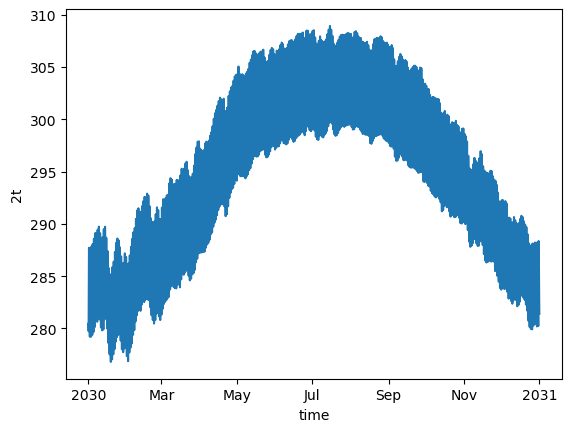

In [23]:
area_data.plot()

Same for ICON

In [43]:
%%time
area_data_icon = data_icon['tas'].sel(time=slice('2030', '2032'))[:,list(range(100000))].mean(dim='cell').compute()

CPU times: user 1.83 s, sys: 164 ms, total: 2 s
Wall time: 6.96 s


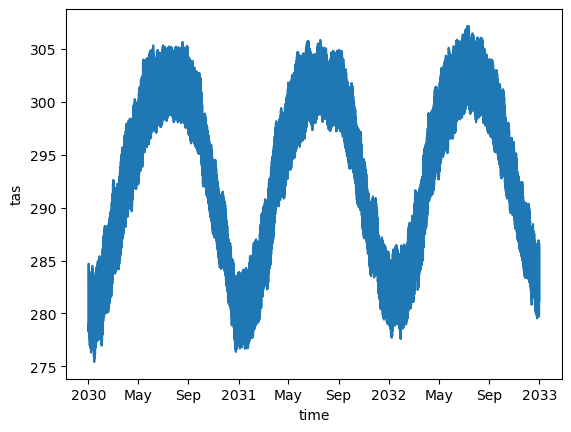

In [25]:
area_data_icon.plot()

Now let's take some ocean data

## 3D ocean, hovmouller diagram

Let's try 3D ocean (sorry, I am oncean guy :))

We will study mixed layer behaviour. We will select point in the middle of Atlantic, and will try to plot hovmouller diagram of first 10 levels for every time step.

In [44]:
pix = hp.ang2pix(
        hp.npix2nside(len(data_example)), theta=-45, phi=30, nest=True, lonlat=True
    )

In [45]:
pix

842410

We only going to compute for 365 values

In [46]:
%%time
hovm = data_ifs_oce_3d['avg_thetao'].sel(time='2030')[:,0:10,pix].compute()

/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/distributed/client.py:3169: UserWarning: Sending large graph of size 51.50 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 2min 18s, sys: 13.5 s, total: 2min 32s
Wall time: 9min 55s


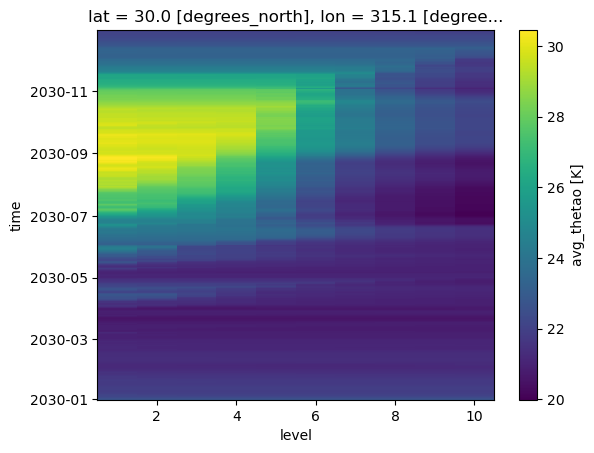

In [14]:
hovm.plot()

In [47]:
%%time
hovm_icon = data_icon_oce['to'].sel(time='2030')[:,0:10,pix].compute()

CPU times: user 369 ms, sys: 51.4 ms, total: 420 ms
Wall time: 1.04 s


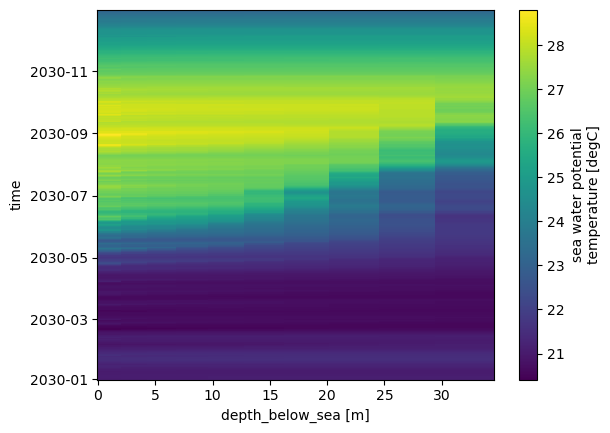

In [48]:
hovm_icon.plot()

No problems to do it for the whole time series with ICON:

In [19]:
%%time
hovm_icon = icon_ocean['to'][:,0:10,pix].compute()

CPU times: user 4.87 s, sys: 411 ms, total: 5.28 s
Wall time: 14 s


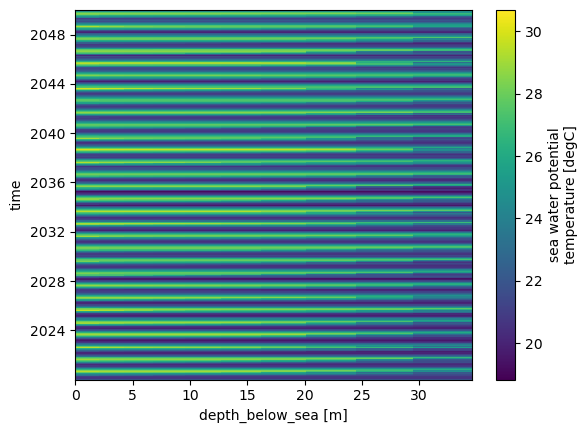

In [22]:
hovm_icon.plot()

## A bit more random data access

Random data access, emulating transect or just bunch of vertical profiles across the ocean

In [40]:
import random

random.seed(42)  # Set a seed for reproducibility
random_numbers = [random.randint(0, 10000) for _ in range(30)]

print(random_numbers)

[1824, 409, 4506, 4012, 3657, 2286, 1679, 8935, 1424, 9674, 6912, 520, 488, 1535, 3582, 3811, 8279, 9863, 434, 9195, 3257, 8928, 6873, 3611, 7359, 9654, 4557, 106, 2615, 6924]


We increase the number of vertical levels to 30

In [43]:
%%time
transect = ocean_3D['avg_thetao'].sel(time='2030')[:,0:30,random_numbers].compute()

CPU times: user 47.1 s, sys: 3.46 s, total: 50.5 s
Wall time: 1min 22s


In [44]:
%%time
transect_icon = icon_ocean['to'].sel(time='2030')[:,0:30,random_numbers].compute()

CPU times: user 426 ms, sys: 52.3 ms, total: 478 ms
Wall time: 936 ms


## Ocean mean speed

In [6]:
import numpy as np

In [12]:
%%time
speed_mean = np.hypot(ocean_3D['avg_uoe'].sel(time='2030')[:,:30,:], ocean_3D['avg_von'].sel(time='2030')[:,:30,:]).mean(dim='time').compute()

/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/distributed/client.py:3169: UserWarning: Sending large graph of size 55.06 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2025-02-11 21:27:03,224 - distributed.worker.memory - WARNING - gc.collect() took 1.064s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.


CPU times: user 3min 2s, sys: 16.3 s, total: 3min 19s
Wall time: 6min 12s


In [11]:
%%time
speed_mean_icon = np.hypot(icon_ocean['u'].sel(time='2030')[:,:30,:], icon_ocean['v'].sel(time='2030')[:,:30,:]).mean(dim='time').compute()

CPU times: user 32.1 s, sys: 2.97 s, total: 35.1 s
Wall time: 1min 32s
